In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
PATH = "C:/Users/rahul/Desktop/Final Year Project/Datasets"
T1 = PATH + "/Inputs & output.xlsx"

In [3]:
data = pd.read_excel(T1, header = 1)

In [4]:
data = data.drop("Number", axis=1)
data = data.drop("Biomass type", axis=1)

In [5]:
data

,M,VM,FC,A,C,O,H,N,S,T (˚C),AFR (kg/kg),Wnet (kW)
0,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,1.8,50.646995
1,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.0,47.490069
2,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,600,2.3,44.021257
3,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,1.8,103.090293
4,52.6,76.6,19.2,4.2,50.9656,38.5116,5.8438,0.4790,0.0000,900,2.0,98.030617
...,...,...,...,...,...,...,...,...,...,...,...,...
1027,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.0,65.234100
1028,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1200,2.3,57.348570
1029,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,1.8,96.825749
1030,38.1,66.0,13.6,20.4,41.5512,32.1584,4.7760,0.8756,0.2388,1500,2.0,92.012450


In [6]:
X = data.iloc[:, :11]
X = X.to_numpy(dtype=float)
X.shape

(1032, 11)

In [7]:
X[2]

array([5.26000e+01, 7.66000e+01, 1.92000e+01, 4.20000e+00, 5.09656e+01,
       3.85116e+01, 5.84380e+00, 4.79000e-01, 0.00000e+00, 6.00000e+02,
       2.30000e+00])

In [8]:
Y = data.iloc[:, 11:]
Y = Y.to_numpy(dtype=float)
Y.shape

(1032, 1)

In [9]:
Y[2]

array([44.0212568])

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650 Ti'

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 1/5, random_state = 1)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

In [12]:
X_test[2]

array([-0.34353008, -0.17485219, -0.24360851, -0.35638173, -0.20954265,
       -0.23296478, -0.34601559, -0.36100575, -0.36506559,  4.45399026,
       -0.35895206])

In [13]:
y_test[2]

array([240.816006])

In [14]:
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

train_ds = TensorDataset(X_train, y_train)
#test_ds = TensorDataset(X_test, y_test)
torch.manual_seed(1)
batch_size = 1
train_dl = DataLoader(train_ds, batch_size, shuffle = True)

In [15]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.firstlayer = nn.Linear(input_size, hidden_size)
        self.secondlayer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.firstlayer(x)
        x = nn.Sigmoid()(x)
        x = self.secondlayer(x)
        return x

    def predict(self, x):
        pred = self.forward(x)
        return pred

In [16]:
network = NeuralNetwork(11, 40, 1).to(device)

In [17]:
network

NeuralNetwork(
  (firstlayer): Linear(in_features=11, out_features=40, bias=True)
  (secondlayer): Linear(in_features=40, out_features=1, bias=True)
)

In [18]:
network.load_state_dict(torch.load("modelStateDict.pth"))

<All keys matched successfully>

In [19]:
num_epochs = 5000
log_epochs = 100
learning_rate = 0.0002
lossfunc = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=learning_rate)
loss_hist = [0] * num_epochs
accuracy_hist = [0]*num_epochs

In [20]:
for epochs in range(num_epochs):
    count = 0
    for x, y in train_dl:
        prediction = network.predict(x)
        loss = lossfunc(prediction, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist[epochs] += loss.item()*y.size(0)
        if(torch.abs(prediction - y) <= torch.tensor(20)): count += 1
        
    loss_hist[epochs] /= len(train_dl.dataset)
    accuracy_hist[epochs] = count/len(train_dl.dataset)
    if epochs % log_epochs==0:
        print(f'Epoch {epochs} Loss 'f'{loss_hist[epochs]:.4f}')
        print(f'Epoch {epochs} Accuracy 'f'{accuracy_hist[epochs]:.4f}')

Epoch 0 Loss 899.0203
Epoch 0 Accuracy 0.7139
Epoch 100 Loss 897.1481
Epoch 100 Accuracy 0.7103
Epoch 200 Loss 898.8196
Epoch 200 Accuracy 0.7200
Epoch 300 Loss 896.1485
Epoch 300 Accuracy 0.7127
Epoch 400 Loss 891.3978
Epoch 400 Accuracy 0.7079
Epoch 500 Loss 890.4762
Epoch 500 Accuracy 0.7188
Epoch 600 Loss 891.5097
Epoch 600 Accuracy 0.7139
Epoch 700 Loss 887.5075
Epoch 700 Accuracy 0.7079
Epoch 800 Loss 889.0970
Epoch 800 Accuracy 0.7200
Epoch 900 Loss 886.5603
Epoch 900 Accuracy 0.7127
Epoch 1000 Loss 886.7219
Epoch 1000 Accuracy 0.7139
Epoch 1100 Loss 884.3673
Epoch 1100 Accuracy 0.7224
Epoch 1200 Loss 887.8939
Epoch 1200 Accuracy 0.7115
Epoch 1300 Loss 884.2517
Epoch 1300 Accuracy 0.7176
Epoch 1400 Loss 883.4902
Epoch 1400 Accuracy 0.7236
Epoch 1500 Loss 879.3814
Epoch 1500 Accuracy 0.7224
Epoch 1600 Loss 879.3575
Epoch 1600 Accuracy 0.7212
Epoch 1700 Loss 877.8641
Epoch 1700 Accuracy 0.7188
Epoch 1800 Loss 876.4265
Epoch 1800 Accuracy 0.7297
Epoch 1900 Loss 874.4281
Epoch 1900 

In [21]:
import pickle
pickle_in1 = open('loss.pickle', 'rb')
loss_hist_prev = pickle.load(pickle_in1)
pickle_in2 = open('accuracy.pickle', 'rb')
accuracy_hist_prev = pickle.load(pickle_in2)

In [22]:
loss_hist_new = []
accuracy_hist_new = []
loss_hist_new = loss_hist_prev + loss_hist
accuracy_hist_new = accuracy_hist_prev + accuracy_hist

In [23]:
len(loss_hist_new)

20000

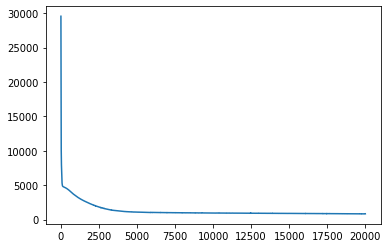

In [24]:
plt.plot(loss_hist_new)

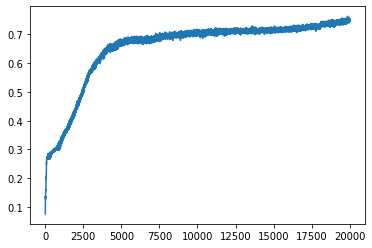

In [25]:
plt.plot(accuracy_hist_new)

In [26]:
pickle.dump(loss_hist_new, open('loss.pickle', 'wb'))
pickle.dump(accuracy_hist_new, open('accuracy.pickle', 'wb'))

In [27]:
torch.save(network.state_dict(), "modelStateDict.pth")